# Class-conditional Diffusion Models

Up until now, we have focused algorithms and architectures of diffusion models, and generated images from randomly noised data.<br>
From now, we consider to steer image generation process with external knowledge - such as, a class, a text sequence, or other modalities (such as, color palette).

In the first example, we explorer very simple and comprehensive approach, traditional class conditional diffusion models.

*(back to [index](https://github.com/tsmatz/diffusion-tutorials/))*

## Architecture

As we saw in previous diffusion models, we fed timestep (or position) information to the model (U-Net) because it's timestep-dependent.

![time conditional model](./assets/time_condition.png)

*From : [DDPM tutorial](./02-ddpm.ipynb)*

> Note : In this example, we use U-Net model in [DDPM tutorial](./02-ddpm.ipynb). (Thus the variance $\sigma_t^2$ is not learned.)

In class conditional diffusion models, we can also feed a class (see below) to make the class information known to the model, if we have class label available during the training.

![class conditional model](./assets/class_condition.png)

## Build and Train model

Now let's see the code (implementation).

Before we start, we need to install the required packages.

In [ ]:
!pip install torch torchvision numpy matplotlib tqdm

### 1. Load data

We load images in **CIFAR-100** dataset and create the dataloader.<br>
Each batch has shape ```[batch_size, 3, 32 32]```.

In [1]:
import torch
from torchvision import datasets, transforms

batch_size = 128

dataset = datasets.CIFAR100(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


Now I show 100 examples.

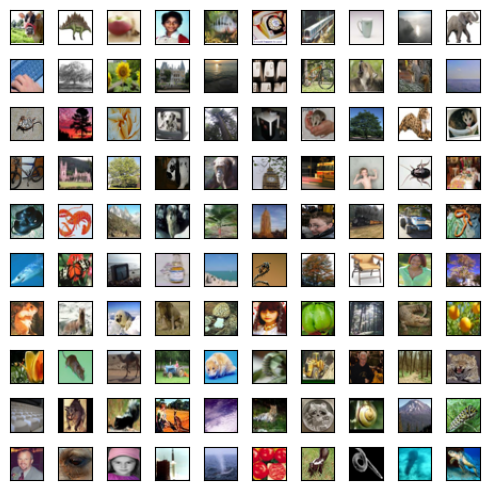

In [2]:
import numpy as np
import matplotlib.pyplot as plt

"""
for _, (data, _) in enumerate(loader):
    images = data[:3]
    break
for i in images:
    channel_last = np.transpose(i.numpy(), (1, 2, 0)) # (C, H, W) --> (H, W, C)
    plt.figure(figsize = (0.4,0.4))
    plt.imshow(channel_last)
    plt.show()
"""
num_row = 10
num_col = 10
fig, axes = plt.subplots(num_row, num_col, figsize=(5,5))
tmp_loader = torch.utils.data.DataLoader(dataset, batch_size=num_row*num_col, shuffle=False)
for data, label in tmp_loader:
    for i in range(num_row*num_col):
        image = data[i].numpy()
        channel_last = np.transpose(image, (1, 2, 0)) # (C, H, W) --> (H, W, C)
        row = i//num_col
        col = i%num_col
        ax = axes[row, col]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(channel_last)
    break
plt.tight_layout()
plt.show()
del tmp_loader

In this dataset, there exist 100 classes as follows.

In [3]:
num_classes = 100
classes = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "crab",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm"
]

Each image belongs to one class.<br>
Here I show class name corresponding to each image.

In [4]:
class_names = [classes[l] for l in label.numpy()]
class_names

['cattle',
 'dinosaur',
 'apple',
 'boy',
 'aquarium_fish',
 'telephone',
 'train',
 'cup',
 'cloud',
 'elephant',
 'keyboard',
 'willow_tree',
 'sunflower',
 'castle',
 'sea',
 'keyboard',
 'bicycle',
 'wolf',
 'squirrel',
 'sea',
 'shrew',
 'pine_tree',
 'rose',
 'television',
 'pine_tree',
 'table',
 'possum',
 'oak_tree',
 'leopard',
 'possum',
 'bicycle',
 'castle',
 'maple_tree',
 'rabbit',
 'chimpanzee',
 'clock',
 'streetcar',
 'boy',
 'cockroach',
 'table',
 'snake',
 'lobster',
 'mountain',
 'wolf',
 'palm_tree',
 'skyscraper',
 'boy',
 'train',
 'tractor',
 'snake',
 'shark',
 'butterfly',
 'television',
 'bottle',
 'sea',
 'bee',
 'maple_tree',
 'chair',
 'woman',
 'maple_tree',
 'hamster',
 'otter',
 'seal',
 'lion',
 'mushroom',
 'girl',
 'sweet_pepper',
 'forest',
 'crocodile',
 'orange',
 'tulip',
 'mouse',
 'camel',
 'tractor',
 'hamster',
 'caterpillar',
 'tractor',
 'man',
 'forest',
 'leopard',
 'keyboard',
 'possum',
 'skunk',
 'kangaroo',
 'cloud',
 'leopard',
 'r

### 2. Build class conditional U-Net $\epsilon_{\theta}(\mathbf{x}, t, y)$

In this example, we modify U-Net used in [DDPM tutorial](./02-ddpm.ipynb) to feed the class label $y$.

Same as timestep $t$, the class information $y$ is also embedded, and it's then merged into the input tensor in residual blocks.<br>
There exist various approaches to merge into the input, but here I apply adaptive group normalization (AdaGN) discussed in [[Dhariwal & Nichol, 2021](https://arxiv.org/pdf/2105.05233)].<br>
This adaptive group normalization (AdaGN) is defined as follows. :

$\displaystyle y_s \verb|GroupNorm|(h) + y_b$

where

- $h$ is the intermediate activations of the residual block following the first convolution
- $y_s$ is a linear projection of the timestep embedding
- $y_b$ is a linear projection of the class embedding

The paper says that AdaGN performs better than Addition + GroupNorm.

> Note : To realize class conditional model, you can also simply stack the class embedding into channels.<br>
> By stacking the class embedding into channels, you don't need to modify existing model architecture. (Only the number of channels is modified.)

The following code is mostly based on [DDPM tutorial](./02-ddpm.ipynb), but above adaptive group normalization (AdaGN) is applied in each block.

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
#
# Define blocks
#

class PositionalEncoding(nn.Module):
    def __init__(
        self,
        base_dim, # 128
        hidden_dim, # 256
        output_dim, # 512
    ):
        super().__init__()

        # In this example, we assume that the number of embedding dimension is always even.
        # (If not, please pad the result.)
        assert(base_dim % 2 == 0)
        self.timestep_dim = base_dim

        self.hidden1 = nn.Linear(
            base_dim,
            hidden_dim)
        self.hidden2 = nn.Linear(
            hidden_dim,
            output_dim)

    def forward(self, picked_up_timesteps):
        # Generate 1 / 10000^{2i / d_e}
        # shape : (timestep_dim / 2, )
        interval = 1.0 / (10000**(torch.arange(0, self.timestep_dim, 2.0).to(device) / self.timestep_dim))
        # Generate t / 10000^{2i / d_e}
        # shape : (batch_size, timestep_dim / 2)
        position = picked_up_timesteps.type(torch.get_default_dtype())
        radian = position[:, None] * interval[None, :]
        # Get sin(t / 10000^{2i / d_e}) and unsqueeze
        # shape : (batch_size, timestep_dim / 2, 1)
        sin = torch.sin(radian).unsqueeze(dim=-1)
        # Get cos(t / 10000^{2i / d_e}) and unsqueeze
        # shape : (batch_size, timestep_dim / 2, 1)
        cos = torch.cos(radian).unsqueeze(dim=-1)
        # Get sinusoidal positional encoding
        # shape : (batch_size, timestep_dim)
        pe_tmp = torch.concat((sin, cos), dim=-1)   # shape : (num_timestep, timestep_dim / 2, 2)
        d = pe_tmp.size()[1]
        pe = pe_tmp.view(-1, d * 2)                 # shape : (num_timestep, timestep_dim)
        # Apply feedforward
        # shape : (batch_size, timestep_dim * 4)
        out = self.hidden1(pe)
        out = F.silu(out)
        out = self.hidden2(out)

        return out

class ResnetBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        num_norm_groups, # 32
        embedding_dim, # 512
    ):
        super().__init__()

        # for normalization
        self.norm1 = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=in_channel,
            eps=1e-06,
        )
        self.norm2 = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=out_channel,
            eps=1e-06,
        )

        # for applying conv
        self.conv1 = nn.Conv2d(
            in_channel,
            out_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )
        self.conv2 = nn.Conv2d(
            out_channel,
            out_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )

        # for time and class projection
        self.linear_time = nn.Linear(embedding_dim, out_channel)
        self.linear_class = nn.Linear(embedding_dim, out_channel)

        # for residual block
        if in_channel != out_channel:
            self.linear_src = nn.Linear(in_channel, out_channel)
        else:
            self.linear_src = None

    def forward(self, x, t_emb, y_emb):
        """
        Parameters
        ----------
        x : torch.tensor((batch_size, in_channel, width, height), dtype=float)
            input x
        t_emb : torch.tensor((batch_size, base_channel_dim * 4), dtype=float)
            timestep embeddings
        y_emb : torch.tensor((batch_size, base_channel_dim * 4), dtype=float)
            class embeddings
        """

        # apply conv
        out = self.norm1(x)
        out = F.silu(out)
        out = self.conv1(out)

        # apply AdaGN (adaptive group normalization)
        t_prj = F.silu(t_emb)
        t_prj = self.linear_time(t_prj)
        t_prj = t_prj[:, :, None, None]

        y_prj = F.silu(y_emb)
        y_prj = self.linear_class(y_prj)
        y_prj = y_prj[:, :, None, None]

        out = out * t_prj + y_prj

        # apply dropout + conv
        out = self.norm2(out)
        out = F.silu(out)
        out = F.dropout(out, p=0.1, training=self.training)
        out = self.conv2(out)

        # apply residual
        if self.linear_src is not None:
            x_trans = x.permute(0, 2, 3, 1)       # (N,C,H,W) --> (N,H,W,C)
            x_trans = self.linear_src(x_trans)
            x_trans = x_trans.permute(0, 3, 1, 2) # (N,H,W,C) --> (N,C,H,W)
            out = out + x_trans
        else:
            out = out + x

        return out

class AttentionBlock(nn.Module):
    def __init__(
        self,
        channel,
        num_norm_groups, # 32
    ):
        super().__init__()

        self.norm = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=channel,
            eps=1e-06,
        )

        self.q_layer = nn.Linear(channel, channel)
        self.k_layer = nn.Linear(channel, channel)
        self.v_layer = nn.Linear(channel, channel)

        self.output_linear = nn.Linear(channel, channel, bias=False)

    def forward(self, x):
        channel = x.size(dim=1)
        height = x.size(dim=2)
        width = x.size(dim=3)

        out = self.norm(x)

        # reshape : (N,C,H,W) --> (N,H*W,C)
        out = out.permute(0, 2, 3, 1)
        out = out.view(-1, height*width, channel)

        # generate query/key/value
        q = self.q_layer(out)
        k = self.k_layer(out)
        v = self.v_layer(out)

        # compute Q K^T
        score = torch.einsum("bic,bjc->bij", q, k)

        # scale the result by 1/sqrt(channel)
        score = score / channel**0.5

        # apply softtmax
        score = F.softmax(score, dim=-1)

        # apply dot product with values
        out = torch.einsum("bij,bjc->bic", score, v)

        # apply final linear
        out = self.output_linear(out)

        # reshape : (N,H*W,C) --> (N,C,H,W)
        out = out.view(-1, height, width, channel)
        out = out.permute(0, 3, 1, 2)

        # apply residual
        out = out + x

        return out

class ResnetAndAttention(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        num_norm_groups, # 32
        embedding_dim, # 512
    ):
        super().__init__()

        self.resnet = ResnetBlock(
            in_channel,
            out_channel,
            num_norm_groups,
            embedding_dim,
        )
        self.attention = AttentionBlock(
            out_channel,
            num_norm_groups,
        )

    def forward(self, x, t_emb, y_emb):
        """
        Parameters
        ----------
        x : torch.tensor((batch_size, in_channel, width, height), dtype=float)
            input x
        t_emb : torch.tensor((batch_size, base_channel_dim * 4), dtype=float)
            timestep embeddings
        y_emb : torch.tensor((batch_size, base_channel_dim * 4), dtype=float)
            class embeddings
        """
        out = self.resnet(x, t_emb, y_emb)
        out = self.attention(out)
        return out

class DownSample(nn.Module):
    def __init__(
        self,
        channel,
    ):
        super().__init__()

        self.conv = nn.Conv2d(
            channel,
            channel,
            kernel_size=3,
            stride=2,
            padding=1,
        )

    def forward(self, x):
        return self.conv(x)

class UpSample(nn.Module):
    def __init__(
        self,
        channel,
    ):
        super().__init__()

        self.conv = nn.Conv2d(
            channel,
            channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )

    def forward(self, x):
        out = F.interpolate(x, scale_factor=2, mode="nearest")
        out = self.conv(out)
        return out

In [7]:
#
# Define U-Net
#

class UNet(nn.Module):
    def __init__(
        self,
        source_channel, # 3
        unet_base_channel, # 128
        num_norm_groups, # 32
        num_classes, # 100
    ):
        super().__init__()

        self.pos_enc = PositionalEncoding(
            base_dim=unet_base_channel,
            hidden_dim=unet_base_channel*2,
            output_dim=unet_base_channel*4,
        )
        self.class_enc = nn.Embedding(num_classes, unet_base_channel*4)

        self.down_conv = nn.Conv2d(
            source_channel,
            unet_base_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )
        self.top_to_down = nn.ModuleList([
            # 1st layer
            ResnetBlock(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            DownSample(
                channel=unet_base_channel,
            ),
            # 2nd layer
            ResnetAndAttention(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            DownSample(
                channel=unet_base_channel*2,
            ),
            # 3rd layer
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            DownSample(
                channel=unet_base_channel*2,
            ),
            # 4th layer
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
        ])
        self.middle = nn.ModuleList([
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            AttentionBlock(
                channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
        ])
        self.bottom_to_up = nn.ModuleList([
            # 1st layer
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            UpSample(
                channel=unet_base_channel*2,
            ),
            # 2nd layer
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            UpSample(
                channel=unet_base_channel*2,
            ),
            # 3rd layer
            ResnetAndAttention(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*3,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            UpSample(
                channel=unet_base_channel*2,
            ),
            # 4th layer
            ResnetBlock(
                in_channel=unet_base_channel*3,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
        ])
        self.norm = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=unet_base_channel,
            eps=1e-06,
        )
        self.up_conv = nn.Conv2d(
            unet_base_channel,
            source_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )

    def forward(self, x, t, y):
        """
        Parameters
        ----------
        x : torch.tensor((batch_size, in_channel, width, height), dtype=float)
            Gaussian-noised images
        t : torch.tensor((batch_size), dtype=int)
            timestep
        y : torch.tensor((batch_size), dtype=int)
            class
        """

        buffer = []

        # generate time embedding
        time_embs = self.pos_enc(t)

        # generate class embedding
        class_embs = self.class_enc(y)

        #
        # Top-to-down
        #

        # apply down-convolution
        out = self.down_conv(x)
        buffer.append(out)
        # apply top-to-down
        for block in self.top_to_down:
            if isinstance(block, ResnetBlock):
                out = block(out, time_embs, class_embs)
            elif isinstance(block, ResnetAndAttention):
                out = block(out, time_embs, class_embs)
            elif isinstance(block, DownSample):
                out = block(out)
            else:
                raise Exception("Unknown block")
            buffer.append(out)

        #
        # Middle
        #
        for block in self.middle:
            if isinstance(block, ResnetBlock):
                out = block(out, time_embs, class_embs)
            elif isinstance(block, AttentionBlock):
                out = block(out)
            else:
                raise Exception("Unknown block")

        #
        # Bottom-to-up
        #

        # apply bottom-to-up
        for block in self.bottom_to_up:
            if isinstance(block, ResnetBlock):
                buf = buffer.pop()
                out = torch.cat((out, buf), dim=1)
                out = block(out, time_embs, class_embs)
            elif isinstance(block, ResnetAndAttention):
                buf = buffer.pop()
                out = torch.cat((out, buf), dim=1)
                out = block(out, time_embs, class_embs)
            elif isinstance(block, UpSample):
                out = block(out)
            else:
                raise Exception("Unknown block")
        # apply up-convolution
        out = self.norm(out)
        out = F.silu(out)
        out = self.up_conv(out)

        assert not buffer

        return out

In [8]:
#
# Generate model (U-Net)
#
unet = UNet(
    source_channel=3,
    unet_base_channel=128,
    num_norm_groups=32,
    num_classes=num_classes,
).to(device)

### 3. Train $\epsilon_{\theta}$

Now let's train $\epsilon_{\theta}$.

The training process is completely same as one in [DDPM tutorial](./02-ddpm.ipynb).

> Note :  I have stopped the training with 500 epochs, but please run more to get more high quality samples.<br>
> The training requires a few days to complete with a single GPU.

In [9]:
import os

# initialize optimizer
opt = torch.optim.Adam(unet.parameters(), lr=2e-4, eps=1e-08)
scheduler = torch.optim.lr_scheduler.LinearLR(
    opt,
    start_factor=1.0/5000,
    end_factor=1.0,
    total_iters=5000)

# 1. Initialize T and alpha
#   (See above note for precision.)
T = 1000
alphas = torch.linspace(start=0.9999, end=0.98, steps=T, dtype=torch.float64).to(device)
alpha_bars = torch.cumprod(alphas, dim=0)
sqrt_alpha_bars_t = torch.sqrt(alpha_bars)
sqrt_one_minus_alpha_bars_t = torch.sqrt(1.0 - alpha_bars)

# remove log file if exists
log_file = "train_loss.log"
if os.path.exists(log_file):
    os.remove(log_file)

# loop
num_epochs = 500
for epoch_idx in range(num_epochs):
    epoch_loss = []
    for batch_idx, (data, y) in enumerate(loader):
        unet.train()
        opt.zero_grad()

        # 2. Pick up x_0 (shape: [64, 3, 32, 32])
        x_0 = data.to(device)
        y_ = y.to(device)

        # 3. Pick up random timestep, t .
        #    Instead of picking up t=1,2, ... ,T ,
        #    here we pick up t=0,1, ... ,T-1 .
        #   (i.e, t == 0 means diffused for 1 step)
        b = x_0.size(dim=0)
        t = torch.randint(T, (b,)).to(device)

        # 4. Generate the seed of noise, epsilon .
        #    We just pick up from 1D standard normal distribution with the same shape,
        #    because off-diagonal elements in covariance is all zero.
        eps = torch.randn_like(x_0).to(device)

        # 5. Compute x_t = sqrt(alpha_bar_t) x_0 + sqrt(1-alpha_bar_t) epsilon
        #    (t == 0 means diffused for 1 step)
        x_t = sqrt_alpha_bars_t[t][:,None,None,None].float() * x_0 + sqrt_one_minus_alpha_bars_t[t][:,None,None,None].float() * eps

        # 6. Get loss and apply gradient (update)
        model_out = unet(x_t, t, y_)
        loss = F.mse_loss(model_out, eps, reduction="mean")
        loss.backward()
        opt.step()
        scheduler.step()

        # log
        epoch_loss.append(loss.item())
        print("epoch{} (iter{}) - loss {:5.4f}".format(epoch_idx+1, batch_idx+1, loss), end="\r")

    # finalize epoch (save log and checkpoint)
    epoch_average_loss = sum(epoch_loss)/len(epoch_loss)
    print("epoch{} (iter{}) - loss {:5.4f}".format(epoch_idx+1, batch_idx+1, epoch_average_loss))
    with open(log_file, "a") as f:
        for l in epoch_loss:
            f.write("%s\n" %l)
    torch.save(unet.state_dict(), f"unet_cond_{epoch_idx}.pt")

print("Done")

epoch1 (iter391) - loss 0.6376
epoch2 (iter391) - loss 0.0728
epoch3 (iter391) - loss 0.0380
epoch4 (iter391) - loss 0.0295
epoch5 (iter391) - loss 0.0264
epoch6 (iter391) - loss 0.0244
epoch7 (iter391) - loss 0.0231
epoch8 (iter391) - loss 0.0219
epoch9 (iter391) - loss 0.0222
epoch10 (iter391) - loss 0.0209
epoch11 (iter391) - loss 0.0207
epoch12 (iter391) - loss 0.0203
epoch13 (iter391) - loss 0.0201
epoch14 (iter391) - loss 0.0197
epoch15 (iter391) - loss 0.0194
epoch16 (iter391) - loss 0.0196
epoch17 (iter391) - loss 0.0191
epoch18 (iter391) - loss 0.0187
epoch19 (iter391) - loss 0.0186
epoch20 (iter391) - loss 0.0189
epoch21 (iter391) - loss 0.0187
epoch22 (iter391) - loss 0.0182
epoch23 (iter391) - loss 0.0184
epoch24 (iter391) - loss 0.0183
epoch25 (iter391) - loss 0.0184
epoch26 (iter391) - loss 0.0183
epoch27 (iter391) - loss 0.0180
epoch28 (iter391) - loss 0.0185
epoch29 (iter391) - loss 0.0180
epoch30 (iter391) - loss 0.0181
epoch31 (iter391) - loss 0.0179
epoch32 (iter391)

## Class-conditional image generation

Now we generate images (sampling) **with class label**.<br>
The following is mostly based on [DDPM tutorial](./02-ddpm.ipynb), but this time I have set class information as an input in the trained model.

In [10]:
import tqdm

def run_inference(unet, class_name, class_list, num_row=10, num_col=10):
    unet.eval()

    # get class
    class_id_list = [i for i,v in enumerate(class_list) if v==class_name]
    if len(class_id_list) == 0:
        raise Exception("class name doesn't exist")
    y = class_id_list[0]
    y_batch = (torch.tensor(y).to(device)).repeat(num_row*num_col)

    # generate sigma_t
    alpha_bars_prev = torch.cat((torch.ones(1).to(device), alpha_bars[:-1]))
    sigma_t_squared = (1.0 - alphas) * (1.0 - alpha_bars_prev) / (1.0 - alpha_bars)
    sigma_t = torch.sqrt(sigma_t_squared)

    # make white noise
    x = torch.randn(num_row*num_col, 3, 32, 32).to(device)

    # generate images (loop)
    #   (t == 0 means diffused for 1 step)
    with torch.no_grad():
        for t in tqdm.tqdm(reversed(range(T)), total=T):
            if t > 0:
                z = torch.randn_like(x).to(device)
            else:
                z = torch.zeros_like(x).to(device)
            t_batch = (torch.tensor(t).to(device)).repeat(num_row*num_col)
            epsilon = unet(x, t_batch, y_batch)
            x = (1.0 / torch.sqrt(alphas[t])).float() * (x - ((1.0 - alphas[t]) / torch.sqrt(1.0 - alpha_bars[t])).float() * epsilon) + \
                sigma_t[t].float() * z

    # reshape to channels-last : (N,C,H,W) --> (N,H,W,C)
    x = x.permute(0, 2, 3, 1)

    # clip
    x = torch.clamp(x, min=0.0, max=1.0)

    # draw
    fig, axes = plt.subplots(num_row, num_col, figsize=(5,5))
    for i in range(num_row*num_col):
        image = x[i].cpu().numpy()
        row = i//num_col
        col = i%num_col
        ax = axes[row, col]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(image)

100%|████████████████████████████████████████████████████████████| 1000/1000 [03:58<00:00,  4.20it/s]


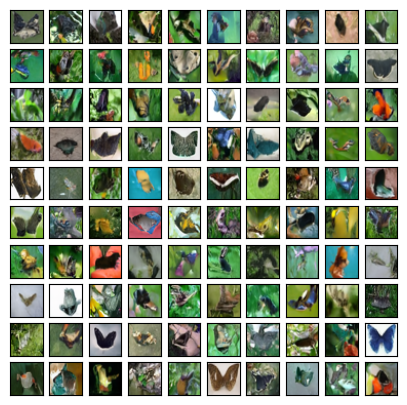

In [11]:
run_inference(unet, "butterfly", class_list=classes)

100%|████████████████████████████████████████████████████████████| 1000/1000 [04:04<00:00,  4.09it/s]


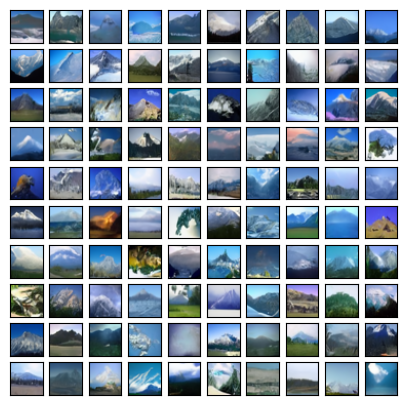

In [12]:
run_inference(unet, "mountain", class_list=classes)

100%|████████████████████████████████████████████████████████████| 1000/1000 [04:01<00:00,  4.14it/s]


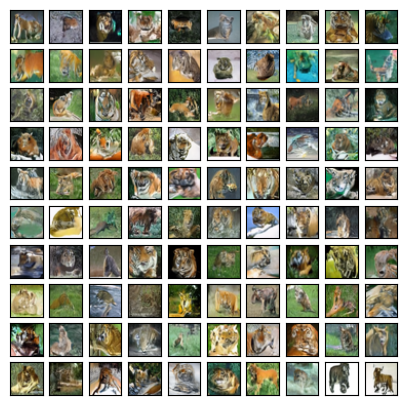

In [13]:
run_inference(unet, "tiger", class_list=classes)

100%|████████████████████████████████████████████████████████████| 1000/1000 [04:01<00:00,  4.13it/s]


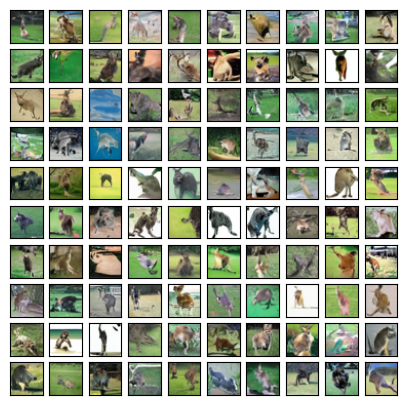

In [14]:
run_inference(unet, "kangaroo", class_list=classes)